# Predict students' final results using k-NN

## Introduction

This project uses the Open University Learning Analytics Dataset (OULAD) to predict if incoming students will succeed or choke. The OULAD "contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules)". 
Sourced from the [OULAD site](https://analyse.kmi.open.ac.uk/open_dataset), seven csv-formatted files include student registration, demographics, courses taken, click data, and assessments. For this project, data from five of the seven files were processed, cleaned, and merged.
To aid educational resource planning, policy-making, and improve successful program completion, this project aims to predict likely final results of incoming students.

## Solution approach

In a separate exercise, five data files were merged into one cohesive dataset.
For this work, we shall use k-Nearest Neighbor Classification to help predict where an incoming student will succeed or choke. We define succeeding as a distinction or pass result, while choking means failing or withdrawing.
Since features, target, and data size are known, k-NN is deemed an appropriate algorithm.

## Setup environment and import data

In [1]:
# Import pandas and numpy
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Import for visualization 
import seaborn as sb 
import matplotlib.pyplot as plt
from pylab import rcParams

# Import for encoding, preprocessing, and modeling
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import metrics

In [2]:
# Set up jupyter notebook to process plots
%matplotlib inline
rcParams['figure.figsize'] = 8,4
sb.set_style('white')

In [3]:
location = "C:\dataState\hub\OULAD_merged.csv"
assessments_wip = pd.read_csv(location, dtype={'id_assessment': str,'id_student': str})
print(assessments_wip.shape)
assessments_wip.sample(n=3)

(180662, 21)


,id_assessment,id_student,when_submitted_days,result_transferred,score_pct,code_module,code_presentation,assessment_type,final_submit_days,weight_assess_pct,...,gender,region,highest_edu,imd_band_pct,age_range,num_prev_attempts,studied_credits,disability,final_result,when_registered_days
117703,34895,624946,163.0,0.0,73.0,FFF,2014B,CMA,227.0,0.0,...,M,North Region,Lower Than A Level,70-80,0-35,0,120,N,Pass,-40.0
67365,34883,2290267,156.0,0.0,81.0,FFF,2013J,CMA,236.0,0.0,...,M,North Region,Lower Than A Level,40-50,0-35,1,120,N,Pass,-67.0
105774,34909,685619,206.0,0.0,78.0,FFF,2014J,CMA,241.0,0.0,...,M,Scotland,HE Qualification,0-10,0-35,0,105,Y,Pass,-32.0


In [4]:
# Check data types
assessments_wip.dtypes

id_assessment            object
id_student               object
when_submitted_days     float64
result_transferred      float64
score_pct               float64
code_module              object
code_presentation        object
assessment_type          object
final_submit_days       float64
weight_assess_pct       float64
mod_pres_days           float64
gender                   object
region                   object
highest_edu              object
imd_band_pct             object
age_range                object
num_prev_attempts         int64
studied_credits           int64
disability               object
final_result             object
when_registered_days    float64
dtype: object

To understand the data better, here are brief descriptions of some of the features

- when_submitted_days  : submission date of an assignment, measured in number of days
- code_module          : an identifier for each module which, in turn, has several assessments
- code_presentation    : an identifier for each presentation which, in turn, has several assessments
- assessment_type      : there are three - tutor marked, computer marked, and a final exam
- region               : geographic region where each student resided while participating
- highest_edu          : the highest education attained by each student, e.g., A Levels or equivalent
- imd_band_pct         : an index that measures deprivation based on income, employment, health, etc
- num_prev_attempts    : number of times each student previously attempted the VLE
- studied_credits      : if previously attempted, this is the current credit load per student
- when_registered_days : when a student registered, measured in days from when a module began
- final_result         : distinction, pass, fail, or withdrawn

## Data cleaning and validation

Before using the data, we need to prepare it for the k-NN algorithm. Missing and duplicated data should be dealt with. Additionally, the dataset should be labeled, features and target should seek to address the requirement, and categories within features should be clearly identifiable.

### Deal with missing data

In [5]:
# Locate and count missing values
assessments_wip.isnull().sum()

id_assessment           6750
id_student                 0
when_submitted_days     6750
result_transferred      6750
score_pct               6750
code_module                0
code_presentation          0
assessment_type         6750
final_submit_days       9615
weight_assess_pct       6750
mod_pres_days           6750
gender                     0
region                     0
highest_edu                0
imd_band_pct               0
age_range                  0
num_prev_attempts          0
studied_credits            0
disability                 0
final_result               0
when_registered_days      48
dtype: int64

Decisions made about missing values should involve all stakeholders.
In our case, most of the missing data resulted from withdrawals. Consequently, corresponding features also have missing data. 
In our case, we can drop all affected instances because they add little value to the analysis.

In [6]:
# Filter out missing values
print("Observation count before missing data are dropped...")
print(assessments_wip.shape)
assessments_wip = assessments_wip.dropna()
print("\nObservation count after missing data are dropped...")
print(assessments_wip.shape)

Observation count before missing data are dropped...
(180662, 21)

Observation count after missing data are dropped...
(171040, 21)


In [7]:
# The before/after missing data count is as expected
# Verify that there are now no features with missing data. 
assessments_wip.isnull().sum()

id_assessment           0
id_student              0
when_submitted_days     0
result_transferred      0
score_pct               0
code_module             0
code_presentation       0
assessment_type         0
final_submit_days       0
weight_assess_pct       0
mod_pres_days           0
gender                  0
region                  0
highest_edu             0
imd_band_pct            0
age_range               0
num_prev_attempts       0
studied_credits         0
disability              0
final_result            0
when_registered_days    0
dtype: int64

### Filter out irrelevant features

The dataset contains features that are not relevant for our project, e.g., student IDs, assessment IDs, disability status, gender etc. These will need to be filtered out before we proceed.
(We emphasize that it does not mean these features should be ignored: including all features would greatly expand project scope.)

In [8]:
# Drop features that will not be used to predict final results
assessments_data = assessments_wip.drop(['id_student', 'result_transferred', 'weight_assess_pct', 'gender', 'disability', 'score_pct'], axis = 1)
assessments_data.sample(n=3)

,id_assessment,when_submitted_days,code_module,code_presentation,assessment_type,final_submit_days,mod_pres_days,region,highest_edu,imd_band_pct,age_range,num_prev_attempts,studied_credits,final_result,when_registered_days
25049,24296,69.0,CCC,2014J,CMA,67.0,269.0,East Midlands Region,A Level or Equivalent,50-60,0-35,1,250,Fail,-18.0
138199,34883,237.0,FFF,2013J,CMA,236.0,268.0,West Midlands Region,Lower Than A Level,50-60,0-35,0,60,Pass,-144.0
35488,14986,88.0,BBB,2013B,TMA,89.0,240.0,South East Region,Lower Than A Level,70-80,0-35,1,120,Pass,-118.0


We are now left with features to be used to predict incoming students' likelihood for success or failure.
As stakeholders, one of the decisions we need to make is to re-categorize 'final result', from the current distinction/pass/fail/withdrawn to just two - succeed or choke. In the new scheme, 'distinction' or 'pass' is labelled as 'succeed' while 'fail' or 'withdrawn' are labelled as 'choke'.

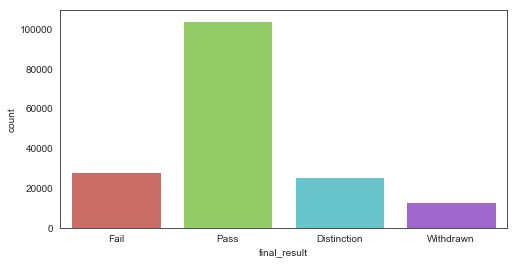

In [9]:
# Given the executive decisions made regarding 'final result' categories, we need to recode our target
# We begin by interrogating the current breakdown of the target 'final_result'
sb.countplot(x='final_result', data=assessments_data, palette='hls')

Per previous discussion, the four outcomes will be rolled into two - succeed (1) or choke (2).

In [10]:
# Our interest is to predict if an incoming student is likely to succeed or choke in the program
# Therefore, we construct categories accordingly
assessments_data['final_result'] = assessments_data['final_result'].str.replace("Distinction", "Succeed")
assessments_data['final_result'] = assessments_data['final_result'].str.replace("Pass", "Succeed")
assessments_data['final_result'] = assessments_data['final_result'].str.replace("Fail", "Choke")
assessments_data['final_result'] = assessments_data['final_result'].str.replace("Withdrawn", "Choke")

In [11]:
assessments_data.groupby('final_result')['final_result'].count()

final_result
Choke       41157
Succeed    129883
Name: final_result, dtype: int64

The final result breakdown is shown: students who succeeded in the current VLE program make up more than three times those who choked for at least two reasons that we know of - failed or withdrew from the program. As in most cases, educators and administrators, in addition to the students themselves, prefer to see as little choking as possible. This is why predicting that likelihood is potentially powerful: interventions can be put in place.

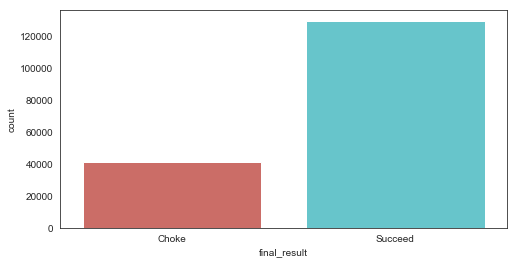

In [12]:
# Confirm the final result categories
sb.countplot(x='final_result', data=assessments_data, palette='hls')

### Verify data state

It is also important to ensure there is no 'dirty' data lurking within the features and target.
To keep the length of this project as short as possible, only data that require further attention are highlighted here.

In [13]:
# We determined that IMD Band data requires cleaning
assessments_data.groupby(['imd_band_pct'])['imd_band_pct'].count()

imd_band_pct
0-10      15771
20-30     18241
20-Oct    17527
30-40     19845
40-50     17386
50-60     17383
60-70     16551
70-80     16670
80-90     16150
90-100    15516
Name: imd_band_pct, dtype: int64

The groupby results show a '20-Oct' category that is unlike the other bands.

[IMD Bands](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/464430/English_Index_of_Multiple_Deprivation_2015_-_Guidance.pdf) are indices that measure "relative deprivation for small areas (or neighbourhoods) in England...calculated by ranking the 32,844 small areas in England from most deprived to least deprived and dividing them into 10 equal groups"

Based on the IMD Bands information from the UK's Department for Communities and Local Government, we can conclude that the '20-Oct' is meant to be '10-20': first, the '10-20' category is missing from a slot that follows '0-10'; second, and perhaps more telling from a data processing perspective, it is the numeric equivalent of October (10) that seems to have been incorrectly captured or interpreted; third, the count of 18,678 instances aligns with each of the other categories' count.

In [14]:
# Clean out the '20-Oct' category
assessments_data['imd_band_pct'] = assessments_data['imd_band_pct'].str.replace("20-Oct", "10-20")
# Confirm replacement result
assessments_data.groupby(['imd_band_pct'])['imd_band_pct'].count()

imd_band_pct
0-10      15771
10-20     17527
20-30     18241
30-40     19845
40-50     17386
50-60     17383
60-70     16551
70-80     16670
80-90     16150
90-100    15516
Name: imd_band_pct, dtype: int64

### Encode features

Since we intend to apply the kNN algorithm, we need to convert our features and target to numerical data. The process entails creating dummy indicators that will be fed to the classification model.
We selected featues that we believe play a role in determining students' learning outcomes: IMD Bands, age, number of previous attempts, current credit load as an indicator of work already done, and eagerness to 'get it done' based on how soon (or late) a student registers.

In [15]:
# Instantiate the label encoder and then process the features we selected in a previous step
le = LabelEncoder()

# Encode IMD Bands
imd_encoded = le.fit_transform(assessments_data['imd_band_pct'])
print("\nIMD Bands are represented as...")
print(np.unique(imd_encoded))

# Encode age range
age_encoded = le.fit_transform(assessments_data['age_range'])
print("\nAge ranges are represented as...")
print(np.unique(age_encoded))

# Encode number of previous attempts
num_prev_attempts_encoded = le.fit_transform(assessments_data['num_prev_attempts'])
print("\nNumber of previous attempts is represented as...")
print(np.unique(num_prev_attempts_encoded))

# Encode previously studied credits
studied_credits_encoded = le.fit_transform(assessments_data['studied_credits'])
print("\nNumber of previously studied credits is represented as...")
print(np.unique(studied_credits_encoded))

# Encode registration day (count from beginning of assessment work)
when_registered_days_encoded = le.fit_transform(assessments_data['when_registered_days'])
print("\nRegistration days from assessment start is represented as...")
print(np.unique(when_registered_days_encoded))


IMD Bands are represented as...
[0 1 2 3 4 5 6 7 8 9]

Age ranges are represented as...
[0 1 2]

Number of previous attempts is represented as...
[0 1 2 3 4 5 6]

Number of previously studied credits is represented as...
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]

Registration days from assessment start is represented as...
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137

Combine features into one list of tuples in preparation for feeding the kNN algorithm

In [16]:
# Combine all applicable features
features = list(zip(imd_encoded, age_encoded, num_prev_attempts_encoded, studied_credits_encoded, when_registered_days_encoded))
features_list = list(set(features))
features_list[:5]

[(5, 1, 0, 5, 166),
 (3, 0, 0, 0, 211),
 (3, 1, 1, 17, 247),
 (1, 1, 0, 22, 246),
 (4, 0, 2, 5, 248)]

The above sample is a list of tuples that contain the features the kNN model will process momentarily

Similar to work encoding done on the features, we also need to encode our target (final result) into binary options

In [17]:
# Here we encode succeed as 1 and choke as 0
target_final_result = assessments_data['final_result']
final_result_encoded = le.fit_transform(target_final_result)
target = final_result_encoded
print("Final result categories are represented as...")
print(np.unique(target))
print("\n...and the target shape is:")
target.shape

Final result categories are represented as...
[0 1]

...and the target shape is:


(171040,)

## kNN model preparation and deployment

### Generate the k-NN classification model

In [18]:
# Use scikit-learn's train_test_split function to split features and target data. 
# This is very important for the model's efficacy: without 'unseen' data to test with, our model would give 'perfect' predictions
# 80/20 or 66/33 are typically used to split the data. The guideline is to use more data for training than for testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) # 80% training, 20% testing

### Evaluate the model

The module metrics, imported from scikit-learn at the beginning of this project, is used to determine accuracy

In [19]:
# Predict classification using the test dataset instantiated above
k_values = [1, 3, 5, 7, 9, 11, 13] 
# More k values can be included here, but the computation is intensive and so a balance must be struck
accuracy_scores = [] # We will append accuracy scores to this list

# Loop through different values of k to predict whether an incoming student will succeed or choke in the VLE program
# Test the accuracy of the predictions
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) # Instantiate a kNN classifier
    knn.fit(X_train, y_train) # Train the kNN model using the datasets we instantiated above
    y_pred = knn.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
print("\nThe predicted values for our test values or our 'pretend' incoming students data are...\n")
print(y_pred)
print("\n...and the accuracy of the predictions for the given k values is:\n")
print(accuracy_scores)


The predicted values for our test values or our 'pretend' incoming students data are...

[1 1 1 ... 1 1 0]

...and the accuracy of the predictions for the given k values is:

[0.8033500935453695, 0.8189604770813844, 0.8221176333021516, 0.8198082319925164, 0.8142247427502338, 0.8093136108512629, 0.805396398503274]


Text(0, 0.5, 'Model Accuracy')

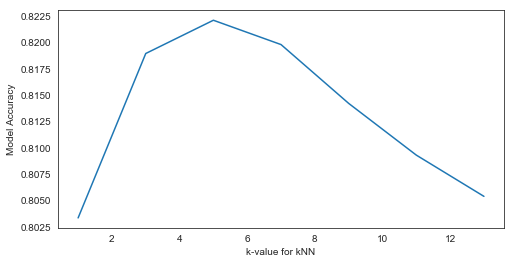

In [20]:
plt.plot(k_values, accuracy_scores)
plt.xlabel('k-value for kNN')
plt.ylabel('Model Accuracy')

The accuracy figure is the proportion of predictations that are correct. 
The model indicates that accuracy is highest at 5 nearest neighbors at just over 82%, and lowest when k = 1 or 13. k = 3 or 7 nearest neighbors also yields good prediction accuracy.
We can therefore use our model to reliably predict if new students are likely to succeed or choke. Education administrators and policy makers can more actively dedicate resources towards those students identified as likely to struggle.

In [21]:
# View a classification report summarizing the above breakdown
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.36      0.47      8215
           1       0.82      0.95      0.88     25993

   micro avg       0.81      0.81      0.81     34208
   macro avg       0.75      0.65      0.67     34208
weighted avg       0.79      0.81      0.78     34208



An important figure in the classification report is the recall of 95% which measures our model's completeness. A simpler way of stating this is that out of all the data predicting success, 95% (of the data) are truly relevant. There is therefore about 5% of the data that are considered noise. The report also indicates that out of ALL the prediction data generated, 81% of the data were truly relevant (weighted avg).

In [22]:
# Another useful item is the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[ 2935,  5280],
       [ 1377, 24616]], dtype=int64)

The confusion matrix tells us that 2,935 and 24,616 are correct predictions, while 1,377 and 5,280 are incorrect. This is a breakdown of the accuracy or precision scores already generated and discussed above.

## Model testing

We conclude the project by testing predictions. One way to do this will be to compare an existing student's profile and prediction with our new student's data.
The 'new' students' profiles will be similar (not same) in some aspects to the existing students. In real life, a new student will still be from planet earth, will still be within some age range, etc., so in that respect we can expect their profile to loosely resemble a former student. This will allow us to gauge how the kNN model will perform when real new students join the program in the future. Until that happens, in the modeling world we carve out test data and separate it from training. For example, student X may reside in London, possess no higher education, and belong in the <=55 year old age bracket.

In [23]:
# To begin predicting incoming students' final results, we shall select a few and use their profiles to create new students
# We shall also pick the same students' final results
print("\nFive students with the following profiles...\n")
print(features[0:171040:40000])
print("imd_encoded, age_encoded, num_prev_attempts_encoded, studied_credits_encoded, when_registered_days_encoded")
print("\n...each obtained these final results\n")
print(target[0:171040:40000])



Five students with the following profiles...

[(9, 1, 1, 5, 265), (9, 1, 1, 17, 252), (1, 0, 0, 17, 156), (8, 1, 0, 5, 256), (5, 0, 0, 5, 204)]
imd_encoded, age_encoded, num_prev_attempts_encoded, studied_credits_encoded, when_registered_days_encoded

...each obtained these final results

[0 1 0 1 0]


In [24]:
# Next, we create a new imaginary student (with a realistic profile)
new_student_0 = np.array([8, 3, 1, 8, 256]).reshape(1, -1) # the suffix has no significance whatsoever

print("\nstudent_0 with this profile:")
print(features[0:1])
print("\nwas used to create this new profile...")
print(new_student_0)
print("\n...and our model predicted this result:")
print(knn.predict(new_student_0))


student_0 with this profile:
[(9, 1, 1, 5, 265)]

was used to create this new profile...
[[  8   3   1   8 256]]

...and our model predicted this result:
[0]


- Student 0:
The new student belongs to a different IMD Band and age category. Additionally, s/he registered on day 256 (compared with 265) and carries a different credit load.
Our model correctly predicted that 'new_student_0' would choke ('final result' 0). This is the same prediction made from the existing first student's profile. In short, despite some profile differences, the new student is "near" enough to the original student to obtain the same classification. Education administrators and policy-makers can use this predictive power of k-NN to re-schedule, re-allocate, re-plan, etc.

## Conclusion

In this project, we used kNN to predict and classify incoming students' likely final result. We rolled up four result categories into two - succeed or choke. 
The project is an example of supervised learning, whereby categories used for classification already exist.
For planning, policy, (re)distribution of resources, etc, we need to be able to predict student's future performances based on data that reflects similar past experiences.
The process included filtering out features we deemed important for predicting the target, that is, the final result.
For the k-NN classification algorithm, as with most other ML tools, checking assumptions about our data matters greatly. The data should contain little statistical noise, it should be labelled, and the chosen features should be relevant.
Lastly, several different paths can be pursued with the same kNN classification project. For example, we can test the impact of different combinations of features on the model's accuracy. We used less than half of the available features here and the combination was good enough to result in more than 80% prediction accuracy.

- By General Ntshalintshali
- portfolio: [datastate.org](https://datastate.org/)